In [1]:
import pandas as pd
import cv2
import os
from skimage.transform import resize
from skimage.feature import corner_harris, corner_peaks, peak_local_max
from skimage.filters import sobel, sobel_h, sobel_v, gaussian
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import imutils
from skimage.color import rgb2gray,rgb2hsv
import time
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
def prepareData(images,labels):
    df=pd.DataFrame(images) #dataframe
    df['Target'] = labels
    x = df.iloc[:,:-1] #input data 
    y = df.iloc[:,-1] #output data
    return x,y
# x,y=prepareData(images,labels)

In [3]:
def Harris_corner(image):
  image = gaussian(image)

  Ix = abs(sobel_v(image))
  Iy = abs(sobel_h(image))

  Ix2 = Ix*Ix
  Iy2 = Iy*Iy
  Ixy = Ix*Iy

  Ix2 = gaussian(Ix2)
  Iy2 = gaussian(Iy2)
  Ixy = gaussian(Ixy)

  k = 0.05

  # determinant
  detA = Ix2 * Iy2 - Ixy ** 2
  # trace
  traceA = Ix2 + Iy2
      
  harris_response = detA - k * traceA ** 2
  
  return harris_response

In [4]:
def draw_corners(image, coords):
  fig, ax = plt.subplots()
  ax.imshow(image, cmap=plt.cm.gray)
  ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',linestyle='None', markersize=3)
  plt.show()

In [13]:
def get_landmarks(img):
  h, w = img.shape
  left_eye = (w//6, 3*h//9, 2*w//5, h//2)
  right_eye = (4*w//7, 3*h//9, 5*w//6, h//2)
  mouth = (w//3, 3*h//4-10, 2*w//3, 7*h//8)
  
  return left_eye, right_eye, mouth

In [14]:
def get_faces_with_landmarks(landmark, face, coords):
  x1, y1, x2, y2 = landmark
  mid = (x1+x2)//2
  
  candidates = []
  for coord in coords:
    y, x = coord
    if(x >= x1 and x <= x2 and y >= y1 and y <= y2): 
      candidates.append(coord)


  if(len(candidates)>0):    
    left = min(candidates, key=lambda coord: abs(coord[1]-x1))
    right = min(candidates, key=lambda coord: abs(coord[1]-x2))
    up = min(candidates, key=lambda coord: np.sqrt((coord[1]-mid)**2 + (coord[0]-y1)**2))
    down = min(candidates, key=lambda coord: np.sqrt((coord[1]-mid)**2 + (coord[0]-y2)**2))
    return [left, right, up, down]
  else:
    return 0  

In [24]:
def apply_corner_features(face):
  landmarks = get_landmarks(face)
  R = Harris_corner(face)
  coords = corner_peaks(R, min_distance=1, threshold_rel=0.001)

  critical_landmarks = []
  for landmark in landmarks:
    features = get_faces_with_landmarks(landmark, face, coords)
    if(features==0):
          continue
    critical_landmarks += features
  critical_landmarks = np.array(critical_landmarks)
  return critical_landmarks
    

### <font color="red"> 🔴 Dont run this cell still working to tune parameters if there is time :)</font>

In [3]:
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc=svm.SVC(probability=True)
model=RandomizedSearchCV(svc,param_grid)

In [25]:
def load_image(path):
    img=cv2.imread(path)
    canvas = np.copy(img)
    return canvas

def show_images(array_img,title,position,boxes,coords):
    for index_image,image in enumerate(array_img):
        show_with_matplotlib(image,title+"_"+ str(index_image+1),position+index_image,boxes,coords)   

def show_with_matplotlib(color_img,title,position,boxes,coords):
    img_RGB=color_img[:,:,::-1]
    ax=plt.subplot(1,1,position)
    plt.imshow(img_RGB)
    #for index,box in enumerate(boxes):
     #   for x,y in coords[0]:
      #      plt.plot(box[1]+y,box[0]+x, 'b+');
    plt.title(title)
    plt.axis('off')


lower_hsv=np.array([0,48,80],dtype="uint8")
upper_hsv=np.array([20,255,255],dtype="uint8")    
def skin_detector_hsv(bgr_image):
    hsv_image=cv2.cvtColor(bgr_image,cv2.COLOR_BGR2HSV) 
    skin_region=cv2.inRange(hsv_image,lower_hsv,upper_hsv)
    return skin_region     



def apply_skin_detector(img):
    detected_skin=skin_detector_hsv(img)
    bgr=cv2.cvtColor(detected_skin,cv2.COLOR_GRAY2BGR)
    bgr=cv2.erode(bgr,np.ones((12,12), np.uint8))
    bgr=cv2.dilate(bgr,np.ones((35,35), np.uint8))
    bgr=cv2.erode(bgr,np.ones((15,15), np.uint8))
    boxes = find_contours(bgr)
    return boxes


def find_contours(img):
    boxes=[]
    imgray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _,thresh=cv2.threshold(imgray,20,255,0)
    contours,hierarchy=cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    # print("number of contours = "+str(len(contours)))
    array=np.array(contours)
    for contour in array:
        xmin,ymin,xmax,ymax=get_boxes(contour)
        if(xmax-xmin <img.shape[1]*0.1 or ymax-ymin < img.shape[0]*0.1):
            continue
        boxes.append((xmin,ymin,xmax,ymax))
    return boxes;

def get_boxes(contour):
    xmin=float('inf')
    ymin=float('inf')
    xmax=0
    ymax=0
    for index,small_contour in enumerate(contour):
        if(small_contour[0][1]<xmin):
            xmin=small_contour[0][1]

        if(small_contour[0][1]>xmax):
            xmax=small_contour[0][1]    

        if(small_contour[0][0]<ymin):
            ymin=small_contour[0][0]

        if(small_contour[0][0]>ymax):
            ymax=small_contour[0][0]     
    return xmin,ymin,xmax,ymax  

def draw_boxes(img,boxes,coords):
    withBoxes = np.copy(img)
    for index,box in enumerate(boxes):
        withBoxes= cv2.rectangle(withBoxes, (box[1],box[0]), (box[3],box[2]), (255, 0, 0), 6)
        for x,y in coords[0]:
            withBoxes = cv2.circle(withBoxes, (box[1]+y,box[0]+x), radius=3, color=(0, 0, 255), thickness=-1)
    return withBoxes


In [26]:
def test_image(img,model):
    img_resize=resize(img,(50,50))
    l=np.array(img_resize).flatten()
    return model.predict_proba([l])
    

In [27]:
def Kaak_Enhanced(final_image,boxes,clf_test):
    contours=[]
    for xmin, ymin, xmax, ymax in boxes: 
        window = final_image[xmin:xmax, ymin:ymax]
        result = test_image(window,clf_test)
        # print(result)
        if(result[0][1]>0.6):   # adjust threshold based on input (video > 0.5) (images > 0.3)
            contours.append((xmin, ymin, xmax, ymax))
            # print((xmin, ymin, xmax, ymax))
    return contours

# Load Our Data  <font color="red"> Dont Run ! (absolute address will be fixed) </font>

In [ ]:
datadir = r'C:\Users\Khaled Hesham\OneDrive\Desktop\ViolaJones\Datasets\faces'  #absolute path iam sorry will be fixed tomorrow inshalah
category=["non_faces","faces"]
images=[]
bf_images=[]
labels=[]

for cat in category:
    datadir = r"C:\Users\Khaled Hesham\OneDrive\Desktop\ViolaJones\Datasets\{}".format(cat)
    for img in os.listdir(datadir):
        # print(r"Datasets/"+cat+"/"+ img)
        if(img==".ipynb_checkpoints"):
            continue
        img_array=io.imread(f"Datasets/"+cat+"/"+ img,as_gray=True)
        resized=resize(img_array,(50,50))
        bf_images.append(resized)
        images.append(np.array(resized).flatten())
        labels.append(category.index(cat))

# Training Our  <font color="green"> Enhanced Model </font>

In [ ]:
x,y = prepareData(images,labels)
SVM = svm.SVC(C=1,kernel='poly',gamma='auto',probability=True)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=0,stratify=y)  # for accurace purposes

In [ ]:
SVM.fit(x_train,y_train)

## <font color="yellow"> Loading Our Model</font> <font color="red"> Dont run this until you want to run our previous trained model  </font>

In [19]:
SVM = joblib.load('SVM_KAAK_2_C_1_Poly_auto.pkl')

## <font color="cyan"> Testing with single image  </font>

In [ ]:
scientists= load_image("no3mn5.jpg")
boxes = apply_skin_detector(scientists)
final_image= cv2.cvtColor(scientists, cv2.COLOR_BGR2GRAY )

In [29]:
contours= Kaak_Enhanced(final_image,boxes,SVM)

In [30]:
contours

[(181, 504, 579, 771)]

In [31]:
coords=[]
for (xmin,ymin,xmax,ymax)  in contours:
    coord=apply_corner_features(final_image[xmin:xmax,ymin:ymax])
    coords.append(coord)
    


(720, 1280, 3)


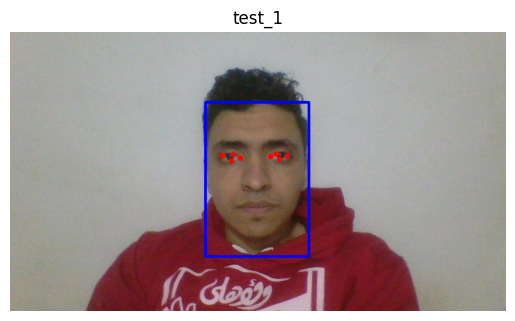

In [23]:
show_images([draw_boxes(scientists,contours,coords)],"test",1,contours,coords)

In [ ]:
predection=SVM.predict(x_test)

### 🔴 <font color="blue"> accuracy here is not an important metric because data trained on is from different domain than our test images on web-cam </font>
### 🔴 <font color="green">I have tried the closest dataset i have found but i believe we can do better if we trained on our images only (if we generate a large number of faces from webcam) </font>

In [ ]:
print("The predicted Data is :")
print(predection)
print("The actual data is:")
print(np.array(y_test))
print(f"The model is {accuracy_score(predection,y_test)*100}% accurate")

# <font color="green"> testing on WebCam </font>

In [28]:
vid = cv2.VideoCapture(0)

while(True):
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
    boxes = apply_skin_detector(frame)
    final_image=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY )
    contours= Kaak_Enhanced(final_image,boxes,SVM)
    coords=[]
    for (xmin,ymin,xmax,ymax)  in contours:
        coord=apply_corner_features(final_image[xmin:xmax,ymin:ymax])
        coords.append(coord)
    img = draw_boxes(frame,contours,coords)


    cv2.imshow('frame', img)
    # the 'q' button is set as theq
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

## <font color="orange"> Saving Our Model </font>

In [34]:
# Save the model as a pickle in a file
joblib.dump(SVM, 'SVM_KAAK_C_1_Poly_auto.pkl')
  

['SVM_KAAK_C_1_Poly_auto.pkl']